# Llama Parser <> LlamaIndex

This notebook is a complete walkthrough for using `LlamaParser` for RAG applications with `LlamaIndex`.

In [ ]:
!pip install llama-index llama-parser sentence-trasformers llama_hub

In [ ]:
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/10q/uber_10q_march_2022.pdf' -O './uber_10q_march_2022.pdf'

## Using old `PDFReader` from LLamaHub as baseline PDF parser

In [47]:
from llama_hub.file.pdf.base import PDFReader
from pathlib import Path
from llama_index import Document


loader = PDFReader()
docs0 = loader.load_data(file=Path('./uber_10q_march_2022.pdf'))
doc_text = "\n\n".join([d.get_content() for d in docs0])
baseline_docs = [Document(text=doc_text)]

### Build Vector Index for the nodes parsed from `PdfReader` and run basic query engine as a baseline approach

In [48]:
from llama_index.node_parser import SentenceSplitter
from llama_index.schema import IndexNode
from llama_index.llms import OpenAI
from llama_index.embeddings import OpenAIEmbedding
from llama_index import VectorStoreIndex, ServiceContext
from llama_index.query_engine import RetrieverQueryEngine


node_parser = SentenceSplitter(chunk_size=512)
baseline_base_nodes = node_parser.get_nodes_from_documents(baseline_docs)
for idx, node in enumerate(baseline_base_nodes):
    node.id_ = f"node-{idx}"

embed_model=OpenAIEmbedding(model="text-embedding-3-small")
llm = OpenAI(model="gpt-4")
service_context = ServiceContext.from_defaults(
    llm=llm, embed_model=embed_model
)

baseline_index = VectorStoreIndex(baseline_base_nodes, service_context=service_context)
baseline_retriever = baseline_index.as_retriever(similarity_top_k=15)
baseline_pdf_query_engine = RetrieverQueryEngine.from_args(
    baseline_retriever, service_context=service_context
)

## Using brand new `LlamaParser` PDF reader for PDF Parsing

we also compare two different retrieval/query engine strategies:
1. Using raw Markdown text as nodes for building index and apply simple query engine for generating the results;
2. Using `MarkdownElementNodeParser` for parsing the `LlamaParser` output Markdown results and building recursive retriever query engine for generation.

In [14]:
# llama-parser is async-first, running the sync code in a notebook requires the use of nest_asyncio
import nest_asyncio

nest_asyncio.apply()

import os
os.environ["LLAMA_CLOUD_API_KEY"] = "llx-"
os.environ["OPENAI_API_KEY"] = "sk-"

In [15]:
from llama_parser import LlamaParser
from llama_index.schema import Document
documents = LlamaParser(result_type="markdown").load_data('./uber_10q_march_2022.pdf')

In [16]:
print(documents[0].text[:1000] + '...')

# SEC Form 10-Q

## UNITED STATES SECURITIES AND EXCHANGE COMMISSION

Washington, D.C. 20549

### FORM 10-Q

(Mark One)

☒ QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the quarterly period ended March 31, 2022

Commission File Number: 001-38902

### UBER TECHNOLOGIES, INC.

(Exact name of registrant as specified in its charter)

Delaware 45-2647441

(State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification No.)

1515 3rd Street

San Francisco, California 94158

(Address of principal executive offices, including zip code)

(415) 612-8582

(Registrant’s telephone number, including area code)

### Securities registered pursuant to Section 12(b) of the Act:

|Title of each class|Trading Symbol(s)|Name of each exchange on which registered|
|---|---|---|
|Common Stock, par value $0.00001 per share|UBER|New York Stock Exchange|

Indicate by check mark whether the registrant (1) has filed all reports required 

In [17]:
from llama_index.node_parser import MarkdownElementNodeParser
from llama_index.llms import OpenAI

node_parser = MarkdownElementNodeParser(llm=OpenAI(model="gpt-4"))

In [18]:
nodes = node_parser.get_nodes_from_documents(documents)
base_nodes, node_mapping = node_parser.get_base_nodes_and_mappings(nodes)

Embeddings have been explicitly disabled. Using MockEmbedding.


56it [14:23, 15.42s/it]


In [19]:
from llama_index import VectorStoreIndex, ServiceContext
from llama_index.embeddings import OpenAIEmbedding

ctx = ServiceContext.from_defaults(llm=OpenAI(model="gpt-4"), embed_model=OpenAIEmbedding(model="text-embedding-3-small"))

index = VectorStoreIndex(nodes=base_nodes, service_context=ctx)
base_index = VectorStoreIndex.from_documents(documents, service_context=ctx)

In [20]:
from llama_index.retrievers import RecursiveRetriever

retriever = RecursiveRetriever(
    "vector", 
    retriever_dict={
        "vector": index.as_retriever(similarity_top_k=15)
    },
    node_dict=node_mapping,
)

In [28]:
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.postprocessor import SentenceTransformerRerank

reranker = SentenceTransformerRerank(top_n=5, model="BAAI/bge-reranker-large")

recursive_query_engine = RetrieverQueryEngine.from_args(retriever, node_postprocessors=[reranker], service_context=ctx)

base_query_engine = base_index.as_query_engine(similarity_top_k=15, node_postprocessors=[reranker], service_context=ctx)

## Comparing `PdfReader vs new LlamaParser` as pdf data parsing methods
we also compare base query engine vs recursive query engine with tables

### Table Query: Queries for Table Question Answering

In [69]:
from IPython.display import Markdown, display


query = "What are the Cash and cash equivalents compared to last year?"

response_0 = baseline_pdf_query_engine.query(query)
print("***********Baseline PDF Query Engine***********")
display(Markdown(f"<b>{response_0}</b>"))


response_1 = base_query_engine.query(query)
print("\n***********New LlamaParser+ Basic Query Engine***********")
display(Markdown(f"<b>{response_1}</b>"))

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParser+ Recursive Retriever Query Engine***********")
display(Markdown(f"<b>{response_2}</b>"))


***********Baseline PDF Query Engine***********


<b>The cash and cash equivalents at the end of the period were $6,607 million, compared to $7,592 million in the previous year.</b>


***********New LlamaParser+ Basic Query Engine***********


<b>As of December 31, 2021, the cash and cash equivalents were $4,295 million. By March 31, 2022, this amount had decreased to $4,184 million.</b>


***********New LlamaParser+ Recursive Retriever Query Engine***********


<b>The cash and cash equivalents were $4,295 as of December 31, 2021, and $4,184 as of March 31, 2022.</b>

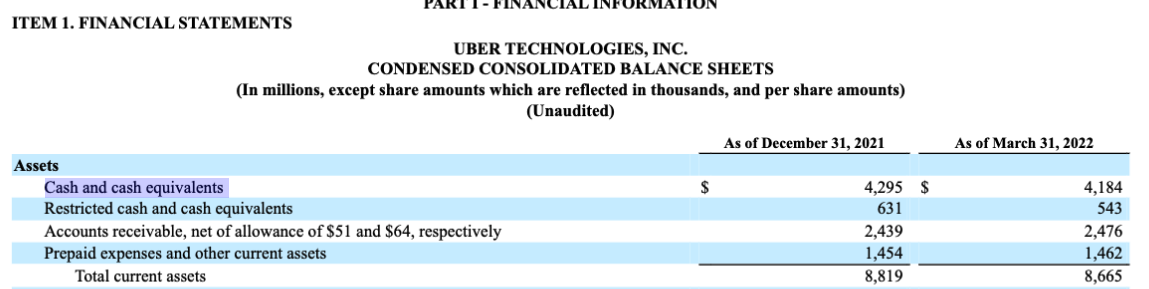

In [74]:
query = "what is Exercise of stock options reported"

response_0 = baseline_pdf_query_engine.query(query)
print("***********Baseline PDF Query Engine***********")
display(Markdown(f"<b>{response_0}</b>"))

response_1 = base_query_engine.query(query)
print("\n***********New LlamaParser+ Basic Query Engine***********")
display(Markdown(f"<b>{response_1}</b>"))

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParser+ Recursive Retriever Query Engine***********")
display(Markdown(f"<b>{response_2}</b>"))

***********Baseline PDF Query Engine***********


<b>The exercise of stock options was reported as 1,093 shares with a value of $6 million for the three months ended March 31, 2022.</b>


***********New LlamaParser+ Basic Query Engine***********


<b>The exercise of stock options is reported as the action of an employee or other eligible party choosing to buy shares at a predetermined price, as specified in their stock option plan. In the context provided, for the period ending March 31, 2021, the exercise of stock options resulted in an increase of 3,518 in common stock and $35 in other comprehensive income. For the period ending March 31, 2022, the exercise of stock options resulted in an increase of 1,093 in common stock and $6 in other comprehensive income.</b>


***********New LlamaParser+ Recursive Retriever Query Engine***********


<b>The exercise of stock options is reported as $1,093.</b>

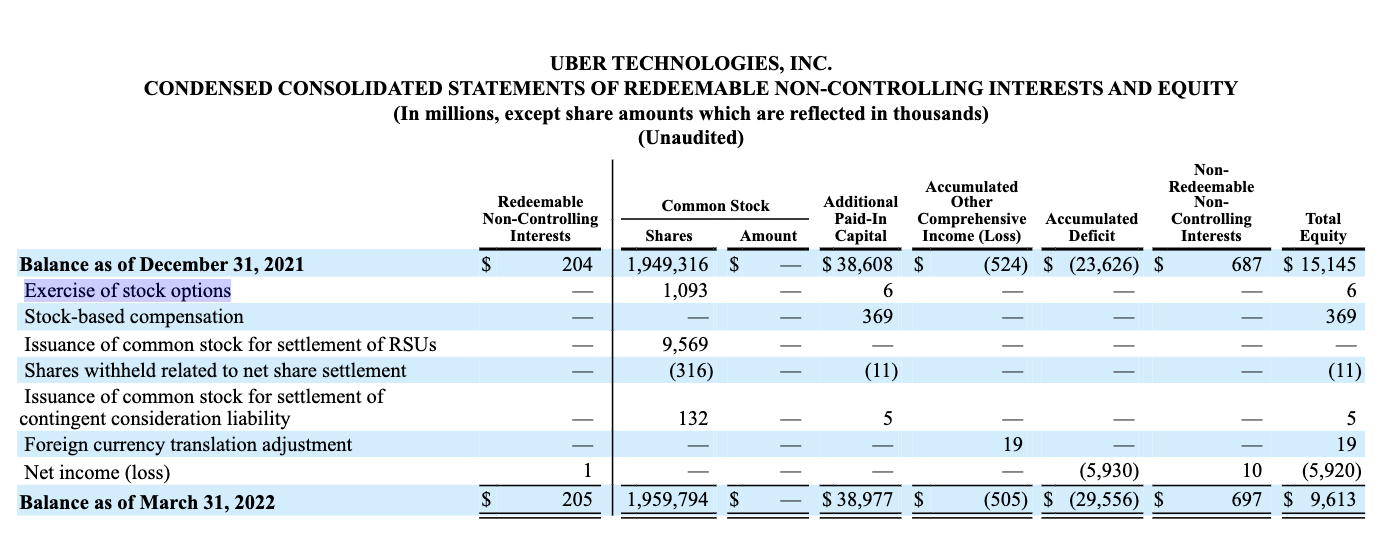

In [76]:
query = "what is Cash flows from investing activities"

response_0 = baseline_pdf_query_engine.query(query)
print("***********Baseline PDF Query Engine***********")
display(Markdown(f"<b>{response_0}</b>"))

response_1 = base_query_engine.query(query)
print("\n***********New LlamaParser+ Basic Query Engine***********")
display(Markdown(f"<b>{response_1}</b>"))

response_2 = recursive_query_engine.query(query)
print("\n***********New LlamaParser+ Recursive Retriever Query Engine***********")
display(Markdown(f"<b>{response_2}</b>"))

***********Baseline PDF Query Engine***********


<b>Cash flows from investing activities refer to the net cash used or provided by various investment-related activities in a specific period. This can include purchases of property and equipment, purchases of marketable and non-marketable equity securities, acquisition of businesses, and proceeds from sales of marketable and non-marketable equity securities. The net cash used in investing activities is calculated by subtracting the total cash outflows from the total cash inflows related to investment activities.</b>


***********New LlamaParser+ Basic Query Engine***********


<b>Cash flows from investing activities refer to the net cash used or provided by various investment-related activities in a specific period. This includes purchases of property and equipment, purchases of marketable and non-marketable equity securities, purchase of notes receivable, proceeds from maturities and sales of marketable securities, proceeds from sale of non-marketable equity securities, and acquisition of businesses, net of cash acquired. For Uber, in the three months ended March 31, 2022, the net cash used in investing activities was $135 million.</b>


***********New LlamaParser+ Recursive Retriever Query Engine***********


<b>Cash flows from investing activities refer to the net cash used in investments during a specific period. For the three months ended March 31, 2022, this was $135 million, mainly due to $62 million spent on property and equipment purchases and $59 million spent on business acquisitions, net of cash acquired. For the same period in 2021, the net cash used in investing activities was $250 million, primarily due to $803 million spent on non-marketable equity securities purchases, $336 million spent on marketable securities purchases, and $216 million spent on note receivable purchases. This was partially offset by $696 million from maturities and sales of marketable securities and $500 million from the sale of non-marketable equity securities.</b>

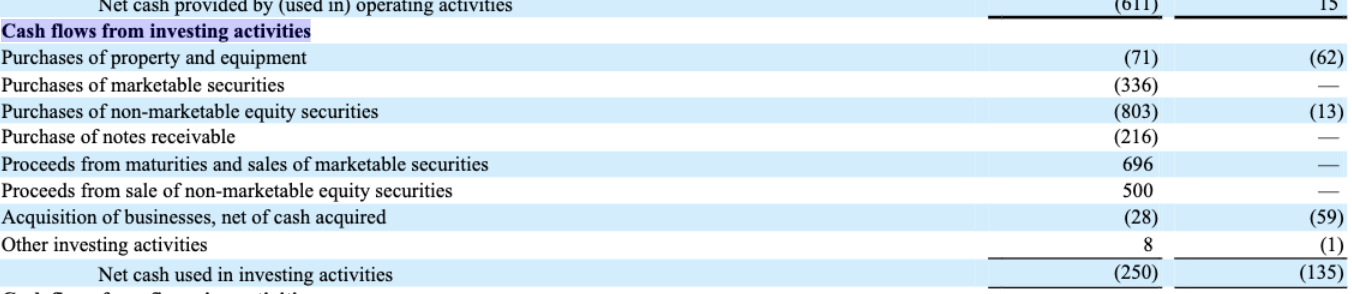